<a href="https://colab.research.google.com/github/haziqhelme/midterm_2015111/blob/main/Copy_of_Q2_B_Midterm_MV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Upload Datasets from Kaggle


In [1]:
from google.colab import files

# Upload the Kaggle API token
uploaded = files.upload()


Saving kaggle.json to kaggle.json


In [2]:
!pip install -q kaggle

In [3]:
!mkdir ~/.kaggle

In [4]:
!cp kaggle.json ~/.kaggle

In [5]:
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets list

ref                                                     title                                       size  lastUpdated          downloadCount  voteCount  usabilityRating  
------------------------------------------------------  -----------------------------------------  -----  -------------------  -------------  ---------  ---------------  
thedrcat/daigt-v2-train-dataset                         DAIGT V2 Train Dataset                      29MB  2023-11-16 01:38:36           3162        260  1.0              
muhammadbinimran/housing-price-prediction-data          Housing Price Prediction Data              763KB  2023-11-21 17:56:32          13234        231  1.0              
thedrcat/daigt-external-train-dataset                   DAIGT External Train Dataset               435MB  2023-11-06 17:10:37            491         55  1.0              
thedrcat/daigt-proper-train-dataset                     DAIGT Proper Train Dataset                 119MB  2023-11-05 14:03:25           2435     

In [7]:
!kaggle datasets download -d 'pranavraikokte/covid19-image-dataset'

 98% 154M/158M [00:04<00:00, 41.6MB/s]
100% 158M/158M [00:04<00:00, 37.1MB/s]


In [8]:
import zipfile

In [9]:
dataset_zip = zipfile.ZipFile('covid19-image-dataset.zip', 'r')
dataset_zip.extractall()
dataset_zip.close()

## 2. Import Library

In [10]:
import torch
from torch import nn

import torchvision
from torchvision import datasets, models
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 3. Getting the Datasets

In [12]:
transform = transforms.Compose(
    [transforms.Resize((32,32)),
     transforms.ToTensor(),  #convert to 4D tensor
     transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])]     # (Mean)(Standard deviation) Have three point because have three channel
)

train_dir='/content/Covid19-dataset/train'
test_dir='/content/Covid19-dataset/test'

train_data = datasets.ImageFolder(root=train_dir,
                                  transform=transform)
test_data = datasets.ImageFolder(root=test_dir,
                                 transform=transform)


In [13]:
class_names = train_data.classes
class_names

['Covid', 'Normal', 'Viral Pneumonia']

In [14]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_data,batch_size=4, shuffle=True)

test_dataloader = DataLoader(test_data,batch_size=4, shuffle=False)

In [15]:
# Check out what's inside the training dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([4, 3, 32, 32]), torch.Size([4]))

In [16]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## 4. Build CNN Model

In [17]:
class   MidtermModel(nn.Module):
  def __init__(self):
    super(MidtermModel,self).__init__()

    # Convolutional layers
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1, padding=0)
    self.bn1 = nn.BatchNorm2d(6)
    self.maxpool1 = nn.MaxPool2d(kernel_size=2,stride=2)
    self.maxpool2 = nn.MaxPool2d(kernel_size=2,stride=2)
    self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0)
    self.bn2 = nn.BatchNorm2d(16)
    self.dropout = nn.Dropout(0.5)

    # Fully connected layers
    # Assuming 56x56 spatial dimensions after pooling
    self.fc1 = nn.Linear(16*5*5,120) # fc is fully connected
    self.fc2 = nn.Linear(120,3) # Adjusted for 3 classes
    # need to flatten first
    self.flatten = nn.Flatten()
    # Activation function
    self.relu = nn.ReLU()


  def forward(self,x):
    # Convolutional layers
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.maxpool1(x)
    x = self.conv2(x)
    x = self.bn2(x)
    x = self.relu(x)
    x = self.maxpool2(x)

    # Flatten before fully connected layers
    x = self.flatten(x)

    # Fully connected layers with ReLU activation
    x = self.fc1(x)
    x = self.relu(x)
    x = self.dropout(x)
    out = self.fc2(x)

    return out

torch.manual_seed(42)
myModel = MidtermModel().to(device)
myModel

MidtermModel(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (bn1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=3, bias=True)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (relu): ReLU()
)

In [18]:
# loss and optimizer

# cross-entropy loss
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(myModel.parameters(),lr=0.001,momentum=0.9)

In [19]:
#Training Loop(Will be used many times)
import time
from tqdm.auto import tqdm

def train_and_validate(model, loss_criterion, optimizer, train_dataloader, test_dataloader, epochs=25, device='cuda'):
    '''
    Function to train and validate
    Parameters
        :param model: Model to train and validate
        :param loss_criterion: Loss Criterion to minimize
        :param optimizer: Optimizer for computing gradients
        :param train_dataloader: DataLoader for training data
        :param test_dataloader: DataLoader for test/validation data
        :param epochs: Number of epochs (default=25)
        :param device: Device to perform computations ('cuda' or 'cpu')

    Returns
        model: Trained Model with best validation accuracy
        history: (dict object): Having training loss, accuracy and validation loss, accuracy
    '''

    start = time.time()
    history = []
    best_acc = 0.0

    for epoch in tqdm(range(epochs)):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))

        model.train()

        train_loss = 0.0
        train_acc = 0.0

        valid_loss = 0.0
        valid_acc = 0.0

        for i, (inputs, labels) in enumerate(train_dataloader):

            inputs = inputs.to(device)
            labels = labels.to(device)

            # Clean existing gradients
            optimizer.zero_grad()

            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)

            # Compute loss
            loss = loss_criterion(outputs, labels)

            # Backpropagate the gradients
            loss.backward()

            # Update the parameters
            optimizer.step()

            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)

            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))

            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))

            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)

        # Validation - No gradient tracking needed
        with torch.no_grad():

            model.eval()

            # Validation loop
            for j, (inputs, labels) in enumerate(test_dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)

                # Compute loss
                loss = loss_criterion(outputs, labels)

                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # Compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() * inputs.size(0)


        # Find average training loss and training accuracy
        avg_train_loss = train_loss / len(train_dataloader.dataset)
        avg_train_acc = train_acc / len(train_dataloader.dataset)

        # Find average validation loss and training accuracy
        avg_test_loss = valid_loss / len(test_dataloader.dataset)
        avg_test_acc = valid_acc / len(test_dataloader.dataset)

        history.append([avg_train_loss, avg_test_loss, avg_train_acc, avg_test_acc])

        epoch_end = time.time()

        print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch, avg_train_loss, avg_train_acc * 100, avg_test_loss, avg_test_acc * 100, epoch_end - epoch_start))

        # Save if the model has best accuracy till now
        if avg_test_acc > best_acc:
            best_acc = avg_test_acc
            best_model = model
            torch.save(best_model, 'best_model.pt')

    return best_model, history

In [20]:
# Train the model for 10 epochs

num_epochs = 10

myModel, history = train_and_validate(myModel, loss_fn, optimizer, train_dataloader, test_dataloader, num_epochs)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1/10
Epoch : 000, Training: Loss: 0.8642, Accuracy: 62.1514%, 
		Validation : Loss : 0.5962, Accuracy: 78.7879%, Time: 12.1664s
Epoch: 2/10
Epoch : 001, Training: Loss: 0.4896, Accuracy: 81.2749%, 
		Validation : Loss : 0.4156, Accuracy: 80.3030%, Time: 10.9566s
Epoch: 3/10
Epoch : 002, Training: Loss: 0.3418, Accuracy: 87.2510%, 
		Validation : Loss : 0.3959, Accuracy: 84.8485%, Time: 10.2987s
Epoch: 4/10
Epoch : 003, Training: Loss: 0.3589, Accuracy: 86.8526%, 
		Validation : Loss : 0.4016, Accuracy: 81.8182%, Time: 9.7363s
Epoch: 5/10
Epoch : 004, Training: Loss: 0.2569, Accuracy: 92.0319%, 
		Validation : Loss : 0.3579, Accuracy: 86.3636%, Time: 10.8928s
Epoch: 6/10
Epoch : 005, Training: Loss: 0.3103, Accuracy: 89.2430%, 
		Validation : Loss : 0.3159, Accuracy: 89.3939%, Time: 11.0820s
Epoch: 7/10
Epoch : 006, Training: Loss: 0.2270, Accuracy: 91.6335%, 
		Validation : Loss : 0.3200, Accuracy: 84.8485%, Time: 9.5698s
Epoch: 8/10
Epoch : 007, Training: Loss: 0.1758, Accuracy

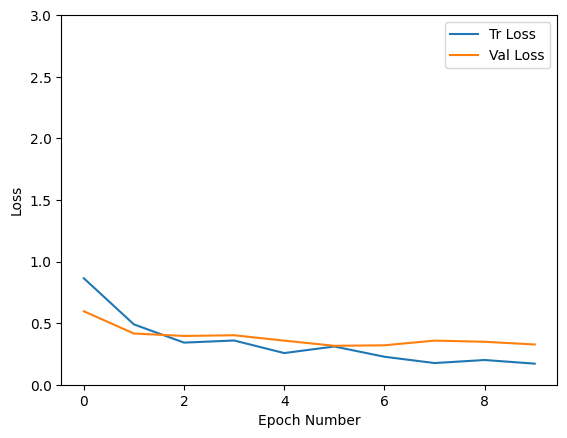

In [21]:
#Analyze the loss curve

def plot_loss(history):
  history = np.array(history)
  plt.plot(history[:,0:2])
  plt.legend(['Tr Loss', 'Val Loss'])
  plt.xlabel('Epoch Number')
  plt.ylabel('Loss')
  plt.ylim(0,3)
  # plt.savefig('cifar10_loss_curve.png')
  plt.show()

plot_loss(history)

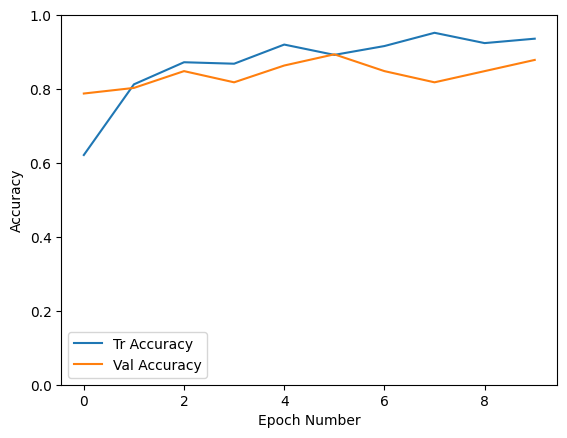

In [22]:
#Analyze the accuracy curve

def plot_accuracy(history):
  history = np.array(history)
  plt.plot(history[:,2:4])
  plt.legend(['Tr Accuracy', 'Val Accuracy'])
  plt.xlabel('Epoch Number')
  plt.ylabel('Accuracy')
  plt.ylim(0,1)
  # plt.savefig('cifar10_accuracy_curve.png')
  plt.show()

plot_accuracy(history)

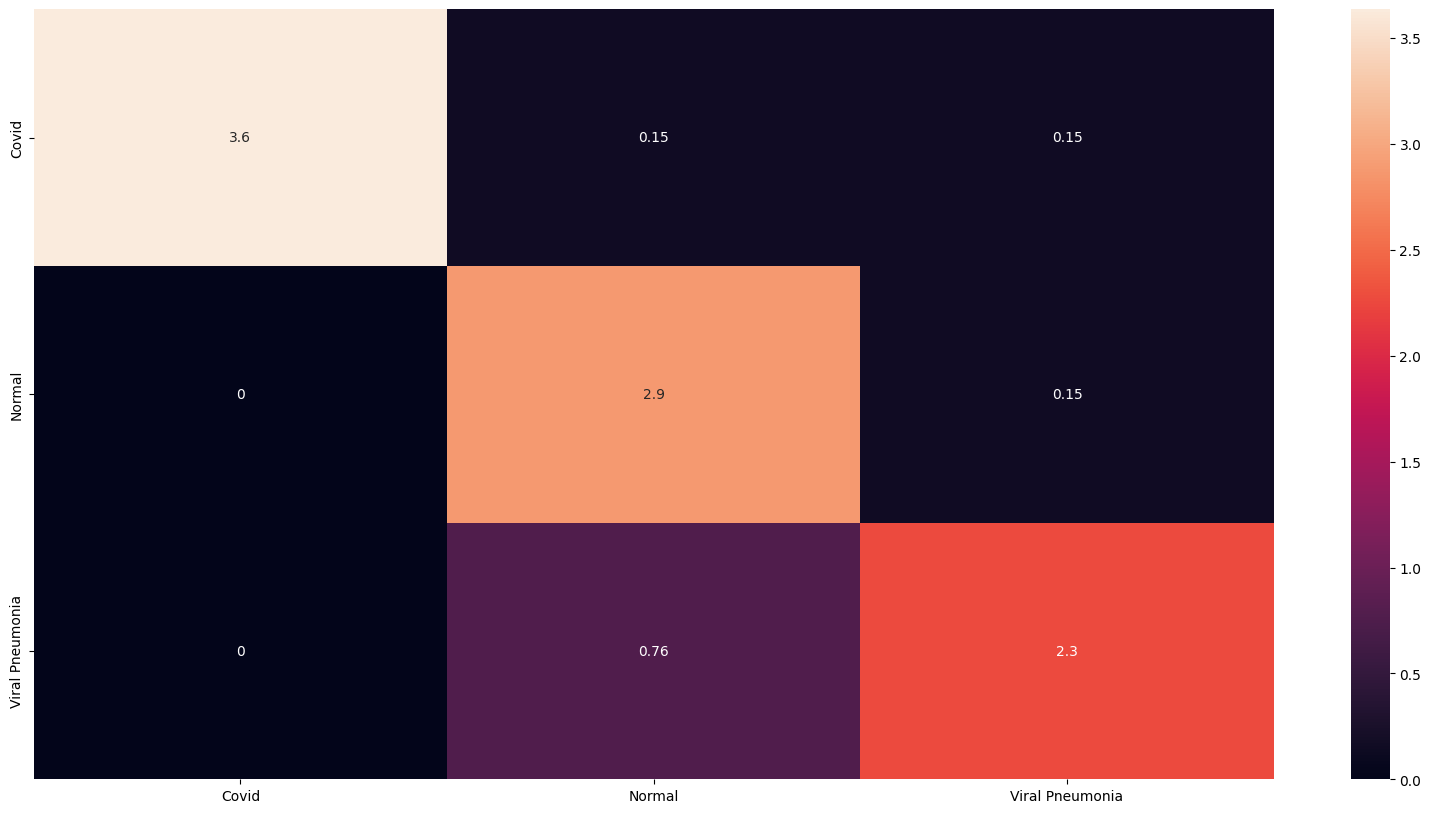

In [23]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

def plot_confusionMatrix(model, test_dataloader):

  y_pred = []
  y_true = []

  model.to('cpu')

  # iterate over test data
  for inputs, labels in test_dataloader:
          output = model(inputs) # Feed Network

          output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
          y_pred.extend(output) # Save Prediction

          labels = labels.data.cpu().numpy()
          y_true.extend(labels) # Save Truth

  # Build confusion matrix
  cf_matrix = confusion_matrix(y_true, y_pred)
  df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in class_names],
                      columns = [i for i in class_names])
  plt.figure(figsize = (20,10))
  sn.heatmap(df_cm, annot=True)
  # plt.savefig('output.png')

plot_confusionMatrix(myModel, test_dataloader)

In [24]:
from sklearn.metrics import accuracy_score
import numpy as np

def calculate_mean_accuracy(model, test_dataloader):
    y_true = []
    y_pred = []

    # Set the model to evaluation mode
    model.eval()

    with torch.no_grad():
        for inputs, labels in test_dataloader:
            outputs = model(inputs)
            _, predictions = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predictions.cpu().numpy())

    # Calculate accuracy for each class
    class_accuracies = accuracy_score(y_true, y_pred, normalize=False)

    # Calculate mean accuracy
    mean_accuracy = accuracy_score(y_true, y_pred)

    # Output the mean accuracy
    print(f"Mean Accuracy: {mean_accuracy}")

# Assuming you have a PyTorch model 'myModel' and a DataLoader 'test_dataloader'
calculate_mean_accuracy(myModel, test_dataloader)

Mean Accuracy: 0.8787878787878788
